In [1]:
# =========================
# Cell 1: Imports & Setup (Kaggle)
# =========================

# Basic libraries
import os
import random
import numpy as np
import pandas as pd

# PyTorch
import torch
from torch.utils.data import Dataset, DataLoader

# Transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Sklearn metrics & utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    balanced_accuracy_score,
    confusion_matrix,
    roc_curve
)

# Plotting
import matplotlib.pyplot as plt

# -------------------------
# Reproducibility
# -------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# -------------------------
# Device configuration
# -------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# Optional: check GPU type in Kaggle
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))


Using device: cuda
Tesla P100-PCIE-16GB


In [2]:
# =========================
# Cell 2: Load Dataset (Kaggle)
# =========================

# Path when dataset is added via Kaggle "Add data"
DATA_PATH = "/kaggle/input/cleaned-bprism/bprism_c - bprism_c.csv"  # CHANGE THIS

# Load CSV
df = pd.read_csv(DATA_PATH)

# Basic checks
assert "text" in df.columns and "hate_label" in df.columns, \
    "Dataset must contain 'text' and 'hate_label' columns"

print("Dataset shape:", df.shape)
print(df.head())


Dataset shape: (29550, 2)
                                                text  hate_label
0  Knowing ki Vikas kitna samjhata hai Priyanka a...           0
1  I am Muhajir .. Aur mere lye sab se Pehly Paki...           0
2  Doctor  sab sahi me ke PhD (in hate politics) ...           0
3  Poore Desh me Patel OBC me aate Hain sirf gujr...           0
4  Sarkar banne ke bad Hindu hit me ek bhi faisla...           1


In [3]:
# =========================
# Cell 3: Data Splitting
# =========================

# 70% Train / 30% Test split (stratified)
train_df, test_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["hate_label"],
    random_state=42
)

# Internal validation: 10% of train
val_frac = 0.10
val_size = int(len(train_df) * val_frac)

val_df = train_df.sample(n=val_size, random_state=42)
train_df = train_df.drop(val_df.index)

# Reset indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)

# Optional: label distribution check
print("\nTrain label distribution:")
print(train_df["hate_label"].value_counts(normalize=True))


Train shape: (18617, 2)
Validation shape: (2068, 2)
Test shape: (8865, 2)

Train label distribution:
hate_label
0    0.534404
1    0.465596
Name: proportion, dtype: float64


In [4]:
# =========================
# Cell 4: mBART Model Setup
# =========================

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

MODEL_NAME = "facebook/mbart-large-50-many-to-many-mmt"
NUM_LABELS = 2
MAX_LEN = 128  # keep same hyperparameters as before

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Load model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS
)

# Move model to GPU/CPU
model.to(DEVICE)

print("mBART model loaded on:", DEVICE)


tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

2025-12-22 11:02:50.938834: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766401371.086158      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766401371.131190      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

Some weights of MBartForSequenceClassification were not initialized from the model checkpoint at facebook/mbart-large-50-many-to-many-mmt and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


mBART model loaded on: cuda


In [6]:
# =========================
# Cell 5: Dataset Class
# =========================

import torch
from torch.utils.data import Dataset

class HateDataset(Dataset):
    """
    Custom Dataset for multilingual text classification
    Compatible with mBART and same structure as MuRIL
    """

    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Tokenize input text
        encoding = self.tokenizer(
            str(self.texts[idx]),
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        # Convert to dictionary
        item = {k: v.squeeze(0) for k, v in encoding.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item


In [7]:
# =========================
# Cell 6: Datasets & DataLoaders
# =========================

from torch.utils.data import DataLoader

# Batch size (same hyperparameters as before)
BATCH_SIZE = 32

# Create Dataset objects
train_dataset = HateDataset(
    train_df["text"].tolist(),
    train_df["hate_label"].tolist(),
    tokenizer,
    MAX_LEN
)

val_dataset = HateDataset(
    val_df["text"].tolist(),
    val_df["hate_label"].tolist(),
    tokenizer,
    MAX_LEN
)

test_dataset = HateDataset(
    test_df["text"].tolist(),
    test_df["hate_label"].tolist(),
    tokenizer,
    MAX_LEN
)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Train batches:", len(train_loader))
print("Validation batches:", len(val_loader))
print("Test batches:", len(test_loader))


Train batches: 582
Validation batches: 65
Test batches: 278


In [9]:
# =========================
# Cell 7: Training Setup + Loop
# =========================

import numpy as np
import torch
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score

# ---- Hyperparameters (unchanged) ----
EPOCHS = 8
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1
PATIENCE = 2

# ---- Optimizer & Scheduler ----
optimizer = AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(WARMUP_RATIO * total_steps),
    num_training_steps=total_steps
)

# ---- Tracking ----
train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_val_f1 = 0.0
patience_counter = 0

# ---- Training Loop ----
for epoch in range(1, EPOCHS + 1):

    # ===== TRAIN =====
    model.train()
    tr_loss = 0.0
    tr_preds, tr_labels = [], []

    for batch in train_loader:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        tr_loss += loss.item()
        tr_preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        tr_labels.extend(batch["labels"].cpu().numpy())

    avg_tr_loss = tr_loss / len(train_loader)
    tr_acc = accuracy_score(tr_labels, tr_preds)

    train_losses.append(avg_tr_loss)
    train_accs.append(tr_acc)

    # ===== VALIDATION =====
    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(DEVICE) for k, v in batch.items()}

            outputs = model(**batch)
            loss = outputs.loss

            val_loss += loss.item()
            val_preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
            val_labels.extend(batch["labels"].cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds)

    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)

    print(
        f"Epoch {epoch} | "
        f"Train Loss: {avg_tr_loss:.4f}, Train Acc: {tr_acc:.4f} | "
        f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}"
    )

    # ---- Early Stopping (Val F1) ----
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
        print("Best model saved.")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break


Epoch 1 | Train Loss: 0.5868, Train Acc: 0.6742 | Val Loss: 0.4940, Val Acc: 0.7398, Val F1: 0.6813
Best model saved.
Epoch 2 | Train Loss: 0.4654, Train Acc: 0.7609 | Val Loss: 0.4950, Val Acc: 0.7394, Val F1: 0.6556
Epoch 3 | Train Loss: 0.3294, Train Acc: 0.8333 | Val Loss: 0.5775, Val Acc: 0.7519, Val F1: 0.7030
Best model saved.
Epoch 4 | Train Loss: 0.2286, Train Acc: 0.8903 | Val Loss: 0.7124, Val Acc: 0.7398, Val F1: 0.7277
Best model saved.
Epoch 5 | Train Loss: 0.1449, Train Acc: 0.9343 | Val Loss: 0.9667, Val Acc: 0.7495, Val F1: 0.7063
Epoch 6 | Train Loss: 0.0873, Train Acc: 0.9629 | Val Loss: 1.1095, Val Acc: 0.7350, Val F1: 0.7257
Early stopping triggered.


In [10]:
# =========================
# Cell 8: Test Evaluation
# =========================

import torch
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    balanced_accuracy_score,
    confusion_matrix,
    roc_curve
)

# ---- Load best model from Cell 7 ----
model.load_state_dict(torch.load("best_model.pt", map_location=DEVICE))
model.to(DEVICE)
model.eval()

# ---- Inference on test set ----
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}

        outputs = model(**batch)
        logits = outputs.logits

        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        y_prob.extend(probs)
        y_pred.extend(preds)
        y_true.extend(batch["labels"].cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# ---- Metrics ----
accuracy = accuracy_score(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)

# Specificity
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

print("Test Results:")
print(f"Accuracy            : {accuracy:.4f}")
print(f"Balanced Accuracy   : {balanced_acc:.4f}")
print(f"Precision           : {precision:.4f}")
print(f"Recall              : {recall:.4f}")
print(f"Specificity         : {specificity:.4f}")
print(f"F1-score            : {f1:.4f}")
print(f"AUC-ROC             : {auc:.4f}")

# ---- Save for next cells (plots / PDF) ----
test_metrics = {
    "accuracy": accuracy,
    "balanced_accuracy": balanced_acc,
    "precision": precision,
    "recall": recall,
    "specificity": specificity,
    "f1": f1,
    "auc": auc
}

fpr, tpr, roc_thresholds = roc_curve(y_true, y_prob)


Test Results:
Accuracy            : 0.7299
Balanced Accuracy   : 0.7307
Precision           : 0.6967
Recall              : 0.7411
Specificity         : 0.7203
F1-score            : 0.7182
AUC-ROC             : 0.8217


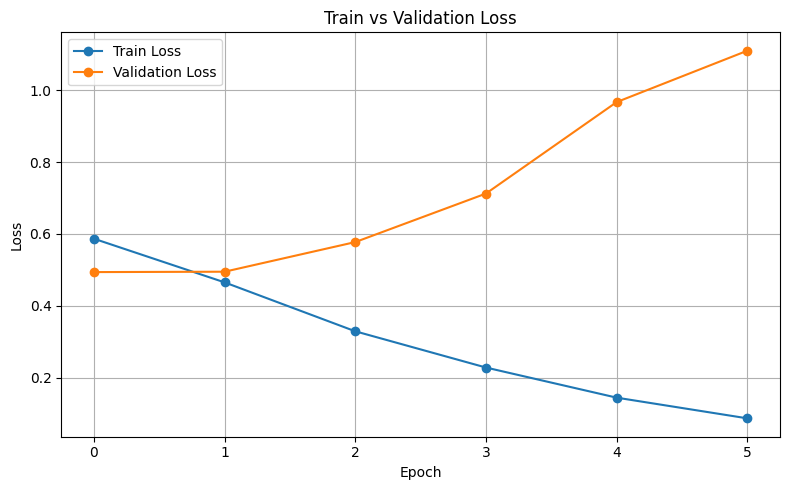

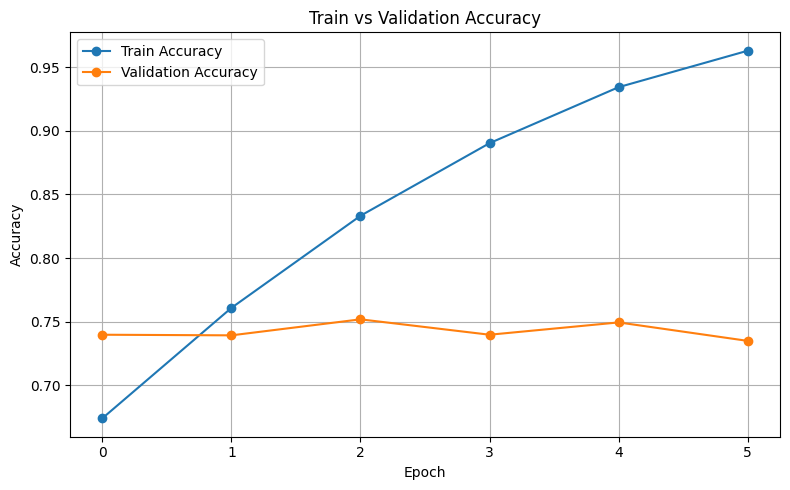

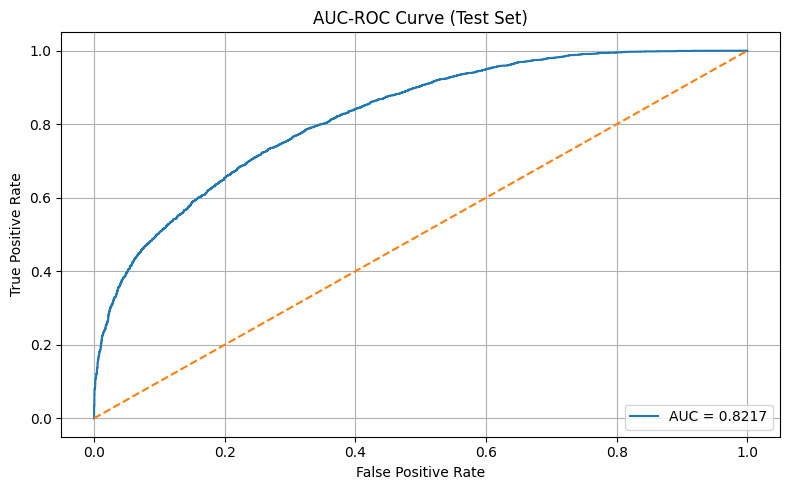

<Figure size 600x500 with 0 Axes>

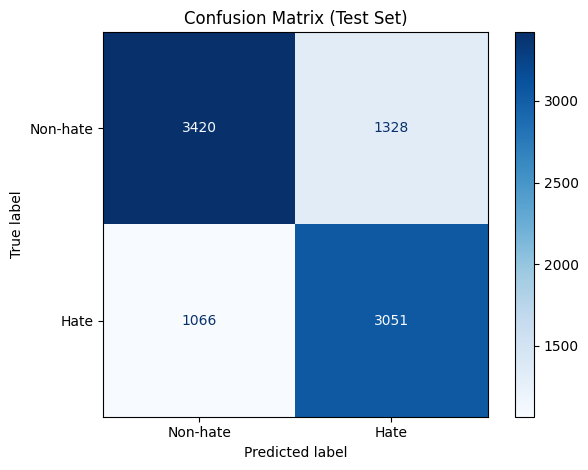

Plots saved to: /kaggle/working/plots


In [11]:
# =========================
# Cell 9: Plots & Save Images
# =========================

import os
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Directory to save plots (Kaggle downloads from here)
SAVE_DIR = "/kaggle/working/plots"
os.makedirs(SAVE_DIR, exist_ok=True)

# ---------- 1) Train vs Validation Loss ----------
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss", marker="o")
plt.plot(val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/train_val_loss.png", dpi=300)
plt.show()

# ---------- 2) Train vs Validation Accuracy ----------
plt.figure(figsize=(8, 5))
plt.plot(train_accs, label="Train Accuracy", marker="o")
plt.plot(val_accs, label="Validation Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/train_val_accuracy.png", dpi=300)
plt.show()

# ---------- 3) AUC-ROC Curve ----------
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"AUC = {test_metrics['auc']:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve (Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/auc_roc.png", dpi=300)
plt.show()

# ---------- 4) Confusion Matrix ----------
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-hate", "Hate"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/confusion_matrix.png", dpi=300)
plt.show()

print("Plots saved to:", SAVE_DIR)


In [13]:
# Install reportlab in Kaggle
!pip install reportlab


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 46.7 MB/s eta 0:00:0000:01


In [14]:
# =========================
# Cell 10: PDF Report Generation
# =========================

from reportlab.platypus import (
    SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle, PageBreak
)
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.pagesizes import A4
from reportlab.lib import colors
from datetime import datetime
import os

# -------- Paths --------
PDF_PATH = "/kaggle/working/mBART_multilingual_report.pdf"
PLOT_DIR = "/kaggle/working/plots"

# -------- PDF setup --------
doc = SimpleDocTemplate(PDF_PATH, pagesize=A4)
styles = getSampleStyleSheet()
story = []

# -------- Title --------
story.append(Paragraph(
    "<b>mBART Multilingual Classification Report</b>",
    styles["Title"]
))
story.append(Spacer(1, 12))

story.append(Paragraph(
    f"Generated on: {datetime.now().strftime('%d %b %Y, %H:%M')}",
    styles["Normal"]
))
story.append(Spacer(1, 20))

# -------- Model Info --------
story.append(Paragraph("<b>Model Information</b>", styles["Heading2"]))
story.append(Paragraph(
    "Model: mBART (encoder–decoder used for sequence classification)<br/>"
    "Task: Multilingual Hate-Speech Classification<br/>"
    "Data Split: 70% Train / 10% Validation / 30% Test",
    styles["Normal"]
))
story.append(Spacer(1, 15))

# -------- Hyperparameters --------
story.append(Paragraph("<b>Training Hyperparameters</b>", styles["Heading2"]))

hyperparams_table = [
    ["Parameter", "Value"],
    ["Learning Rate", LEARNING_RATE],
    ["Batch Size", BATCH_SIZE],
    ["Epochs", EPOCHS],
    ["Optimizer", "AdamW"],
    ["Scheduler", "Linear + Warmup"],
    ["Warmup Ratio", WARMUP_RATIO],
    ["Max Sequence Length", MAX_LEN],
    ["Early Stopping", f"Patience = {PATIENCE} (Val F1)"],
]

table = Table(hyperparams_table, colWidths=[220, 180])
table.setStyle(TableStyle([
    ("BACKGROUND", (0,0), (-1,0), colors.lightgrey),
    ("GRID", (0,0), (-1,-1), 1, colors.black),
    ("FONT", (0,0), (-1,0), "Helvetica-Bold"),
]))
story.append(table)
story.append(PageBreak())

# -------- Metrics --------
story.append(Paragraph("<b>Test Set Evaluation Metrics</b>", styles["Heading2"]))

metrics_table = [
    ["Metric", "Value"],
    ["Accuracy", f"{test_metrics['accuracy']:.4f}"],
    ["Balanced Accuracy", f"{test_metrics['balanced_accuracy']:.4f}"],
    ["Precision", f"{test_metrics['precision']:.4f}"],
    ["Recall", f"{test_metrics['recall']:.4f}"],
    ["Specificity", f"{test_metrics['specificity']:.4f}"],
    ["F1-score", f"{test_metrics['f1']:.4f}"],
    ["AUC-ROC", f"{test_metrics['auc']:.4f}"],
]

table = Table(metrics_table, colWidths=[220, 180])
table.setStyle(TableStyle([
    ("BACKGROUND", (0,0), (-1,0), colors.lightgrey),
    ("GRID", (0,0), (-1,-1), 1, colors.black),
    ("FONT", (0,0), (-1,0), "Helvetica-Bold"),
]))
story.append(table)
story.append(PageBreak())

# -------- Plots --------
def add_plot(title, filename):
    story.append(Paragraph(f"<b>{title}</b>", styles["Heading2"]))
    story.append(Spacer(1, 10))
    story.append(Image(os.path.join(PLOT_DIR, filename), width=400, height=300))
    story.append(Spacer(1, 20))

add_plot("Train vs Validation Loss", "train_val_loss.png")
add_plot("Train vs Validation Accuracy", "train_val_accuracy.png")
add_plot("AUC-ROC Curve", "auc_roc.png")
add_plot("Confusion Matrix", "confusion_matrix.png")

# -------- Footer --------
story.append(Spacer(1, 20))
story.append(Paragraph(
    "Note: Best model selected using validation F1-score with early stopping. "
    "Final metrics are reported on the unseen test set.",
    styles["Normal"]
))

# -------- Build PDF --------
doc.build(story)

print("PDF report generated successfully:")
print(PDF_PATH)


PDF report generated successfully:
/kaggle/working/mBART_multilingual_report.pdf
